## CorrIA


- This notebook presents a code, called CorrIA, that allows to measure intrinsic alignments of galaxies from a given survey, by computing correlations between their 2D observed shapes.

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import linalg
from scipy.spatial import cKDTree
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d

from astropy.io import fits
from astropy.table import Table, Column
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import z_at_value
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.coordinates import concatenate
from astropy import units as u

from matplotlib.patches import Ellipse
from scipy.spatial.transform import Rotation

import treecorr
import random

import torch
from torch.distributions import Uniform

from sbi.utils import BoxUniform
from sbi.analysis import pairplot
from sbi.inference import NPE, SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
    prepare_for_sbi
)

from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import BallTree

import math
import os

from scipy.ndimage import gaussian_filter
import time, glob

In [69]:
# Cosmological parameters

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [68]:
# Function required for further work 

def get_galaxy_orientation_angle(e1,e2):
    return 0.5*np.arctan2(e2,e1)

def abs_e(e1,e2):
    return np.sqrt(e1*e1+e2*e2)

def a_b(e1,e2):
    e = abs_e(e1,e2)
    return 1+e,1-e  

def e_complex(a,b,r):
    abs_e = (1-(b/a)) / (1+(b/a))
    e1 = abs_e*np.cos(2*r)
    e2 = abs_e*np.sin(2*r)
    return e1, e2

### Downloading the data for analysis

Observed ellipticity : $e = e_1+ie_2$

In [10]:
# LRG-UNIONS

unions_lrg_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/code/projet_stage/sbi/unions_lrg_cross.fits')

names = [name for name in unions_lrg_table.colnames if len(unions_lrg_table[name].shape) <= 1]
filtered_tbl = unions_lrg_table[names]

unions_lrg = filtered_tbl.to_pandas()
unions_lrg.columns


nb_unions_lrg = len(unions_lrg)

unions_lrg_index = unions_lrg.index
unions_lrg_index=np.array(unions_lrg_index)





unions_lrg_table2 = Table.read('/Users/antonincorinaldi/Documents/stage césure/code/projet_stage/sbi/unions_lrg_cross2.fits')

names = [name for name in unions_lrg_table2.colnames if len(unions_lrg_table2[name].shape) <= 1]
filtered_tbl = unions_lrg_table2[names]

unions_lrg2 = filtered_tbl.to_pandas()
unions_lrg2.columns


nb_unions_lrg2 = len(unions_lrg2)

unions_lrg_index2 = unions_lrg2.index
unions_lrg_index2=np.array(unions_lrg_index2)





chi = cosmo.comoving_distance(unions_lrg2['Z'] ).value


x = chi * np.cos(unions_lrg['RA'].values * np.pi/180) * np.cos(unions_lrg['Dec'].values * np.pi/180)
y = chi * np.sin(unions_lrg['RA'].values * np.pi/180) * np.cos(unions_lrg['Dec'].values * np.pi/180) 
z = chi * np.sin(unions_lrg['Dec'].values * np.pi/180)


positions = np.vstack([x, y, z]).T


e1 = unions_lrg['e1'].values ; e2 = unions_lrg['e2'].values ; w = unions_lrg['w_iv'].values

In [42]:
# CMASS-UNIONS

cmass_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/code/projet_stage/sbi/unions_cmass_cross.fits')

names = [name for name in cmass_table.colnames if len(cmass_table[name].shape) <= 1]
filtered_tbl = cmass_table[names]

unions_cmass = filtered_tbl.to_pandas()
unions_cmass.columns





cmass_table2 = Table.read('/Users/antonincorinaldi/Documents/stage césure/code/projet_stage/sbi/unions_cmass_cross2.fits')

names = [name for name in cmass_table2.colnames if len(cmass_table2[name].shape) <= 1]
filtered_tbl = cmass_table2[names]

unions_cmass2 = filtered_tbl.to_pandas()
unions_cmass2.columns





chi = cosmo.comoving_distance(unions_cmass2['Z'] ).value


x = chi * np.cos(unions_cmass['RA'].values * np.pi / 180) * np.cos(unions_cmass['Dec'].values * np.pi / 180)
y = chi * np.sin(unions_cmass['RA'].values * np.pi / 180) * np.cos(unions_cmass['Dec'].values * np.pi / 180)
z = chi * np.sin(unions_cmass['Dec'].values * np.pi / 180)

positions = np.vstack((x, y, z)).T 



e1 = unions_cmass['e1'].values ; e2 = unions_cmass['e2'].values ; w = unions_cmass['w_iv'].values

In [54]:
# BGS-UNIONS

unions_bgs_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/code/projet_stage/sbi/unions_bgs_cross.fits')

names = [name for name in unions_bgs_table.colnames if len(unions_bgs_table[name].shape) <= 1]
filtered_tbl = unions_bgs_table[names]

unions_bgs = filtered_tbl.to_pandas()
unions_bgs.columns

unions_bgs=unions_bgs[:100_000]




unions_bgs2_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/code/projet_stage/sbi/unions_bgs_cross2.fits')

names = [name for name in unions_bgs2_table.colnames if len(unions_bgs2_table[name].shape) <= 1]
filtered_tbl = unions_bgs2_table[names]

unions_bgs2 = filtered_tbl.to_pandas()
unions_bgs2.columns

unions_bgs2=unions_bgs2[:100_000]





chi = cosmo.comoving_distance(unions_bgs2['Z'] ).value


x = chi * np.cos(unions_bgs['RA'].values * np.pi / 180) * np.cos(unions_bgs['Dec'].values * np.pi / 180)
y = chi * np.sin(unions_bgs['RA'].values * np.pi / 180) * np.cos(unions_bgs['Dec'].values * np.pi / 180)
z = chi * np.sin(unions_bgs['Dec'].values * np.pi / 180)

positions = np.vstack((x, y, z)).T 



e1 = unions_bgs['e1'].values ; e2 = unions_bgs['e2'].values ; w = unions_bgs['w_iv'].values

### Computation of the relative angle $\Phi_2$ (see figure 2 of (1)) on the sphere between two galaxies 

(1) Kilbinger et al. 2013 https://arxiv.org/pdf/1212.3338

The coordinates of the two galaxies on the sky are $(\alpha_1,\delta_1)$ and $(\alpha_2,\delta_2)$. The angle $\Phi_2$ of figure 2 is given by the following geometric equation : 

### $\sin(\Phi_2)=\frac{\cos(\delta_2)\sin(\delta_1)-\sin(\delta_2)\cos(\delta_1)\cos(\alpha_2-\alpha_1)}{\sin(\theta)}$

In [55]:
# Function that computes Phi_2

def get_angles(ra1, dec1, ra2, dec2, u_coords='deg'):
    
    c1 = SkyCoord(ra1, dec1, unit=u_coords, frame='icrs', equinox='J2000.0')
    c2 = SkyCoord(ra2, dec2, unit=u_coords, frame='icrs', equinox='J2000.0')
    theta = c1.position_angle(c2)

    A = np.cos(dec2) * np.sin(dec1)
    B = np.cos(ra2 - ra1) * np.sin(dec2) * np.cos(dec1)
    C = np.sin(theta)
    
    phi = np.arcsin((A-B)/C)

    return phi.value, theta.value

### Finding pairs of galaxies (i,j) in the $r_p-\Pi$ plane (and one computes then $\Phi_2$ for each pair of galaxies)

In [12]:
# LRG-UNIONS


# Bins of r_p and Pi
rp_bins = np.linspace(0.1, 60, 25) ; pi_bins = np.linspace(-60, 60, 50)  


# Compute the pairs of galaxies with a BallTree
tree = BallTree(positions, leaf_size=40, metric='euclidean')

max_sep = np.sqrt(60**2 + 60**2)
indices = tree.query_radius(positions, r=max_sep) # The array indices contains for each galaxy the indices of its neighbors within the maximum separation distance


# Pairs of galaxies...
pairs = np.array([(i, j) for i, neighbors in enumerate(indices) for j in neighbors if j != i])
#...and the corresponding indices
i_indices = pairs[:,0] ; j_indices = pairs[:,1]


# Compute the relative comoving distance along the line-of-sight between the two galaxies
pi = chi[j_indices] - chi[i_indices]


# Compute the transverse comoving distance between the two galaxies
chi12 = np.linalg.norm(positions[j_indices] - positions[i_indices], axis=1)


# Compute the projected separation rp
rp = np.sqrt(chi12**2 - pi**2)


# Compute the angles \Phi_2 and \theta, the angle between the two galaxies in the plane of the sky 
phi, theta = get_angles(
    unions_lrg['RA'].values[i_indices], unions_lrg['Dec'].values[i_indices],
    unions_lrg['RA'].values[j_indices], unions_lrg['Dec'].values[j_indices],
    u_coords='deg'
)


# Group the quantities in a same array
pairs_lrg = np.column_stack((i_indices, j_indices, rp, pi, phi))

/opt/homebrew/lib/python3.12/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in arcsin
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [44]:
# CMASS-UNIONS


rp_bins = np.linspace(0.1, 60, 25) ; pi_bins = np.linspace(-60, 60, 50)  

tree = BallTree(positions, leaf_size=40, metric='euclidean')

max_sep = np.sqrt(60**2 + 60**2)
indices = tree.query_radius(positions, r=max_sep)

pairs = np.array([(i, j) for i, neighbors in enumerate(indices) for j in neighbors if j != i])

i_indices = pairs[:, 0] ; j_indices = pairs[:, 1]

pi = chi[j_indices] - chi[i_indices]

chi12 = np.linalg.norm(positions[j_indices] - positions[i_indices], axis=1)

rp = np.sqrt(chi12**2 - pi**2)

phi, theta = get_angles(
    unions_cmass['RA'].values[i_indices], unions_cmass['Dec'].values[i_indices],
    unions_cmass['RA'].values[j_indices], unions_cmass['Dec'].values[j_indices],
    u_coords='deg'
)

pairs_cmass = np.column_stack((i_indices, j_indices, rp, pi, phi))

/opt/homebrew/lib/python3.12/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in arcsin
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


In [56]:
# BGS-UNIONS


rp_bins = np.linspace(0.1, 60, 25) ; pi_bins = np.linspace(-60, 60, 50)  

tree = BallTree(positions, leaf_size=40, metric='euclidean')

max_sep = np.sqrt(60**2 + 60**2)
indices = tree.query_radius(positions, r=max_sep)

pairs = np.array([(i, j) for i, neighbors in enumerate(indices) for j in neighbors if j != i])

i_indices = pairs[:, 0] ; j_indices = pairs[:, 1]

pi = chi[j_indices] - chi[i_indices]

chi12 = np.linalg.norm(positions[j_indices] - positions[i_indices], axis=1)

rp = np.sqrt(chi12**2 - pi**2)

phi, theta = get_angles(
    unions_bgs['RA'].values[i_indices], unions_bgs['Dec'].values[i_indices],
    unions_bgs['RA'].values[j_indices], unions_bgs['Dec'].values[j_indices],
    u_coords='deg'
)

pairs_bgs = np.column_stack((i_indices, j_indices, rp, pi, phi))

/opt/homebrew/lib/python3.12/site-packages/astropy/units/quantity.py:658: RuntimeWarning: invalid value encountered in arcsin
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


### Computation of ($e_t$,$e_\times$) and $(\xi_{g+},\xi_{g\times})$ (let do this analysis for the LRG first)

The ellipticities $e_t$ and $e_\times$ are related to $\Phi_2$ through the following equations :

$e_t=-e_1\cos(2\Phi_2)-e_2\sin(2\Phi_2)$

$e_\times=e_1\sin(2\Phi_2)-e_2\cos(2\Phi_2)$

Then, one measures the 2-point correlation functions $\xi_{g+}$ and $\xi_{g\times}$ by computing the weighted mean of $e_t$ and $e_\times$ in bins of $r_p$ and $\Pi$ :

### $\xi_{g+}(r_p,\Pi)=~<e_t>~=\frac{\sum_{i}w_ie_{t,i}}{\sum_{i}w_i}$

### $\xi_{g\times}(r_p,\Pi)=~<e_\times>~=\frac{\sum_{i}w_ie_{\times,i}}{\sum_{i}w_i}$

where $w$ is the weight for each galaxy defined by :

### $w = \frac{1}{2\sigma_{SN}^2+\sigma_{\epsilon_1}^2+\sigma_{\epsilon_2}^2}$

with $\sigma_{SN}$ is the galaxy shape noise ; $\sigma_{e_1}$ and $\sigma_{e_2}$ are the variance of the ellipticity of the galaxy (https://arxiv.org/pdf/2412.01790)

In [35]:
rp_values = pairs_lrg[:, 2] ; pi_values = pairs_lrg[:, 3] ; angle_values = pairs_lrg[:, 4] ; e1_values = e1[j_indices] ; e2_values = e2[j_indices]  ; weights = w[j_indices]


# Computation of e_t
e_tangential = - e1_values * np.cos(2 * angle_values) - e2_values * np.sin(2 * angle_values)


valid = ~np.isnan(e_tangential)
rp_values = rp_values[valid]
pi_values = pi_values[valid]
e_tangential = e_tangential[valid]
weights = weights[valid]


# Computation of xi_g+
weighted_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, e_tangential * weights, statistic='sum', bins=[rp_bins, pi_bins]
)

weight_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, weights, statistic='sum', bins=[rp_bins, pi_bins]
)


stat_weighted_lrg = np.divide(weighted_sum, weight_sum, out=np.zeros_like(weighted_sum), where=weight_sum != 0)








rp_values = pairs_lrg[:, 2] ; pi_values = pairs_lrg[:, 3] ; angle_values = pairs_lrg[:, 4] ; e1_values = e1[j_indices] ; e2_values = e2[j_indices]  ; weights = w[j_indices]


# Computation of e_x
e_cross = e1_values * np.sin(2 * angle_values) - e2_values * np.cos(2 * angle_values)


valid = ~np.isnan(e_cross)
rp_values = rp_values[valid]
pi_values = pi_values[valid]
e_cross = e_cross[valid]
weights = weights[valid]



# Computation of xi_gx
weighted_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, e_cross * weights, statistic='sum', bins=[rp_bins, pi_bins]
)

weight_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, weights, statistic='sum', bins=[rp_bins, pi_bins]
)


stat2_weighted_lrg = np.divide(weighted_sum, weight_sum, out=np.zeros_like(weighted_sum), where=weight_sum != 0)

### Plotting of $(\xi_{g+},\xi_{g\times})$ (= RSD diagrams)

In [33]:
def make_rsd_diagram(xi_gn_p_results, xi_gn_x_results, rmin=60, sigma=2, contourf=True, vmin=None, vmax=None, log=False, title_p='', title_x='', title_save=''):


    smoothed_xi_gn_p_results = gaussian_filter(xi_gn_p_results, sigma=sigma)
    smoothed_xi_gn_x_results = gaussian_filter(xi_gn_x_results, sigma=sigma)

    if log:
        print('do nothing')
    else:
        smoothed_xi_gn_p_results[ smoothed_xi_gn_p_results < vmin ] = vmin
        smoothed_xi_gn_x_results[ smoothed_xi_gn_x_results < vmin ] = vmin

        smoothed_xi_gn_p_results[ smoothed_xi_gn_p_results > vmax ] = vmax
        smoothed_xi_gn_x_results[ smoothed_xi_gn_x_results > vmax ] = vmax



    plt.figure(figsize=(12, 8))


    plt.subplot(121)

    if contourf:
        plt.contourf(smoothed_xi_gn_p_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)
    else:
        plt.imshow(smoothed_xi_gn_p_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)
    
    plt.xlim(0, rmin)
    plt.ylim(-rmin, rmin)
    plt.gca().set_aspect('equal')
    plt.xticks([20, 40, 60]) 
    plt.colorbar()
    plt.ylabel(r'$\Pi$ [Mpc]', fontsize=15)
    plt.xlabel(r'$r_p$ [Mpc]', fontsize=15)
    plt.title(title_p, fontsize=15)




    plt.subplot(122)
    if contourf:
        plt.contourf(smoothed_xi_gn_x_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)
    else:
        plt.imshow(smoothed_xi_gn_x_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)

    plt.xlim(0, rmin)
    plt.ylim(-rmin, rmin)
    plt.gca().set_aspect('equal')
    plt.xticks([20, 40, 60]) 
    plt.colorbar()
    plt.ylabel(r'$\Pi$ [Mpc]', fontsize=15)
    plt.xlabel(r'$r_p$ [Mpc]', fontsize=15)
    plt.title(title_x, fontsize=15)

    plt.tight_layout()
    plt.savefig(title_save, bbox_inches='tight')
    plt.show()

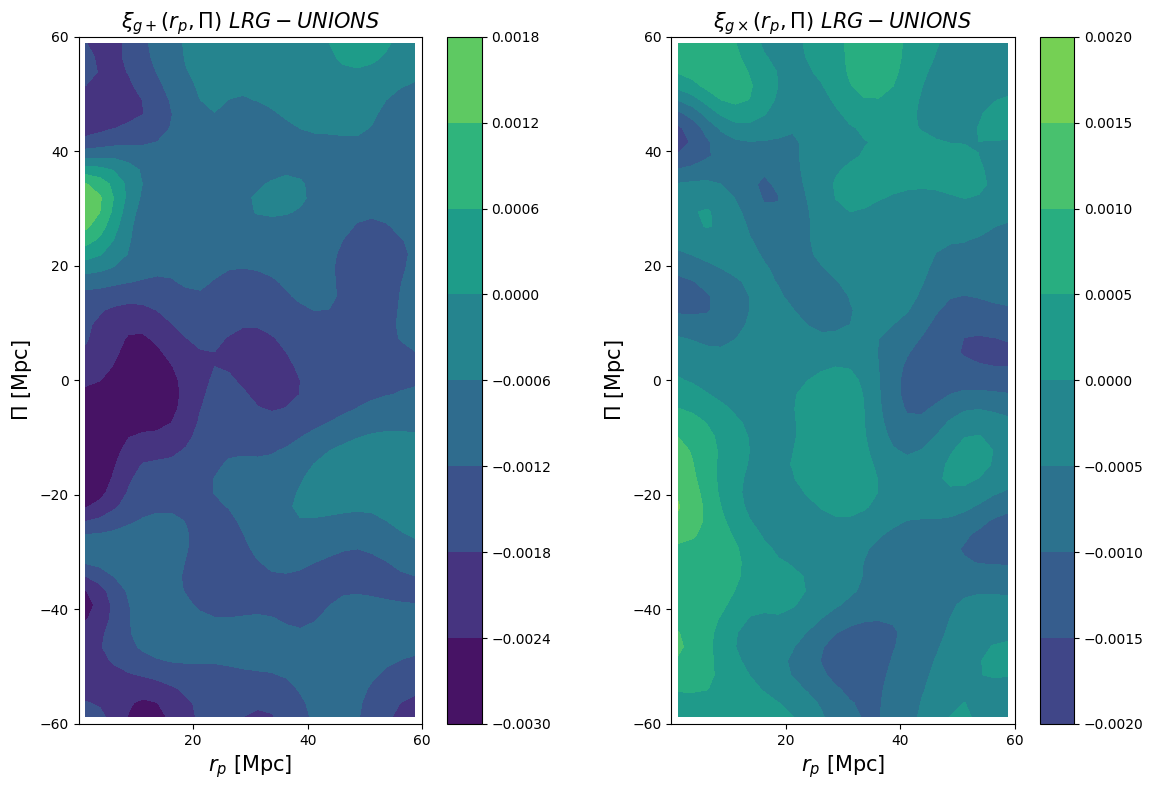

In [26]:
make_rsd_diagram(stat_weighted_lrg, stat2_weighted_lrg, rmin=60, sigma=2, contourf=True, vmin=-0.003, vmax=0.003, log=False,title_p=r'$\xi_{g+}(r_p,\Pi)~LRG-UNIONS$', title_x=r'$\xi_{g\times}(r_p,\Pi)~LRG-UNIONS$', title_save='xig+x_lrg.pdf')

### Computation of $<\vert e \vert>~=~\left<\sqrt{e_1^2+e_2^2}\right>$ in bins of $r_p$ and $\Pi$

In [30]:
rp_values = pairs_lrg[:, 2] ; pi_values = pairs_lrg[:, 3] ; angle_values = pairs_lrg[:, 4] ; e1_values = e1[j_indices] ; e2_values = e2[j_indices]  ; weights = w[j_indices]


e = np.sqrt(e1_values**2 + e2_values**2)


valid = ~np.isnan(e)
rp_values = rp_values[valid]
pi_values = pi_values[valid]
e = e[valid]
weights = weights[valid]


weighted_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, e * weights, statistic='sum', bins=[rp_bins, pi_bins]
)

weight_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, weights, statistic='sum', bins=[rp_bins, pi_bins]
)


stat_weighted_lrg = np.divide(weighted_sum, weight_sum, out=np.zeros_like(weighted_sum), where=weight_sum != 0)

In [31]:
def make_rsd_diagram2(xi_gn_p_results, rmin=60, sigma=2, contourf=True, vmin=None, vmax=None, log=False, title_p='', title_save=''):


    smoothed_xi_gn_p_results = gaussian_filter(xi_gn_p_results, sigma=sigma)

    if log:
        print('do nothing')
    else:
        smoothed_xi_gn_p_results[ smoothed_xi_gn_p_results < vmin ] = vmin

        smoothed_xi_gn_p_results[ smoothed_xi_gn_p_results > vmax ] = vmax



    plt.figure(figsize=(12, 8))



    if contourf:
        plt.contourf(smoothed_xi_gn_p_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)
    else:
        plt.imshow(smoothed_xi_gn_p_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)
    
    plt.xlim(0, rmin)
    plt.ylim(-rmin, rmin)
    plt.gca().set_aspect('equal')
    plt.xticks([20, 40, 60]) 
    plt.colorbar()
    plt.ylabel(r'$\Pi$ [Mpc]', fontsize=15)
    plt.xlabel(r'$r_p$ [Mpc]', fontsize=15)
    plt.title(title_p, fontsize=15)
    plt.savefig(title_save, bbox_inches='tight')


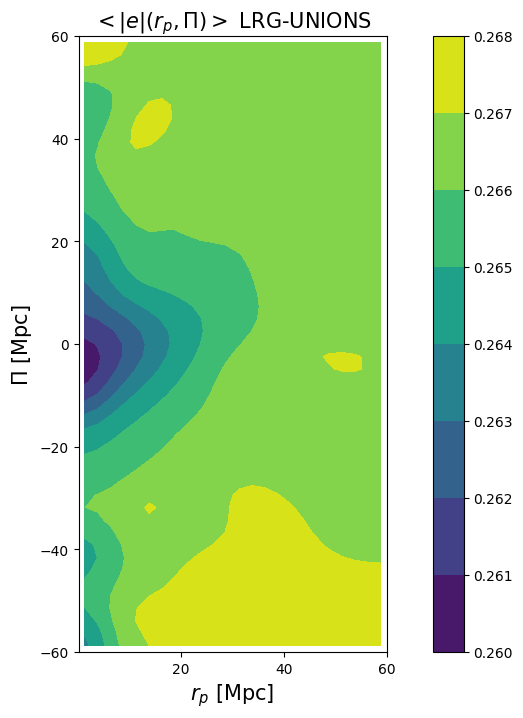

In [32]:
make_rsd_diagram2(stat_weighted_lrg, rmin=60, sigma=2, contourf=True, vmin=0.26, vmax=0.268, log=False,title_p=r'$<\vert e \vert(r_p,\Pi)>$ LRG-UNIONS', title_save='e_lrg.pdf')

### Comparison of CorrIA with TreeCorr (https://ui.adsabs.harvard.edu/abs/2015ascl.soft08007J/abstract)

In [27]:
# Code to compute xi_g+ et xi_gx with TreeCorr

nrp = 20 ; npi = 50

shape_cat = treecorr.Catalog(x=x,y=y,z=z,g1=e1,g2=e2,w=w)

pi = np.linspace(-60,60,npi)


xi_gp = [] ; xi_gp = list(xi_gp) ; xi_gc = [] ; xi_gc = list(xi_gc)
rp = [] ; rp = list(rp) ; var = [] ; var = list(var)


for i in np.arange(0, npi-1):
    ng = treecorr.NGCorrelation(nbins=nrp, 
                                min_sep = 0,
                                max_sep = 60.,
                                min_rpar = pi[i],
                                max_rpar = pi[i+1],
                                bin_type='Linear',
                                bin_slop=0.1,
                                angle_slop=0.1)
                                
    ng.process(shape_cat, shape_cat, metric ='Euclidean')

    xi_p = ng.raw_xi ; xi_c = ng.raw_xi_im ; var2 = ng.raw_varxi ; r = ng.logr
    xi_gp.append(xi_p) ; xi_gc.append(xi_c) ; var.append(var2) ; rp.append(r) 
    

xi_gp_lrg=np.array(xi_gp) ; xi_gc_lrg=np.array(xi_gc) ; var = np.array(var) ; r_lrg = np.array(rp)

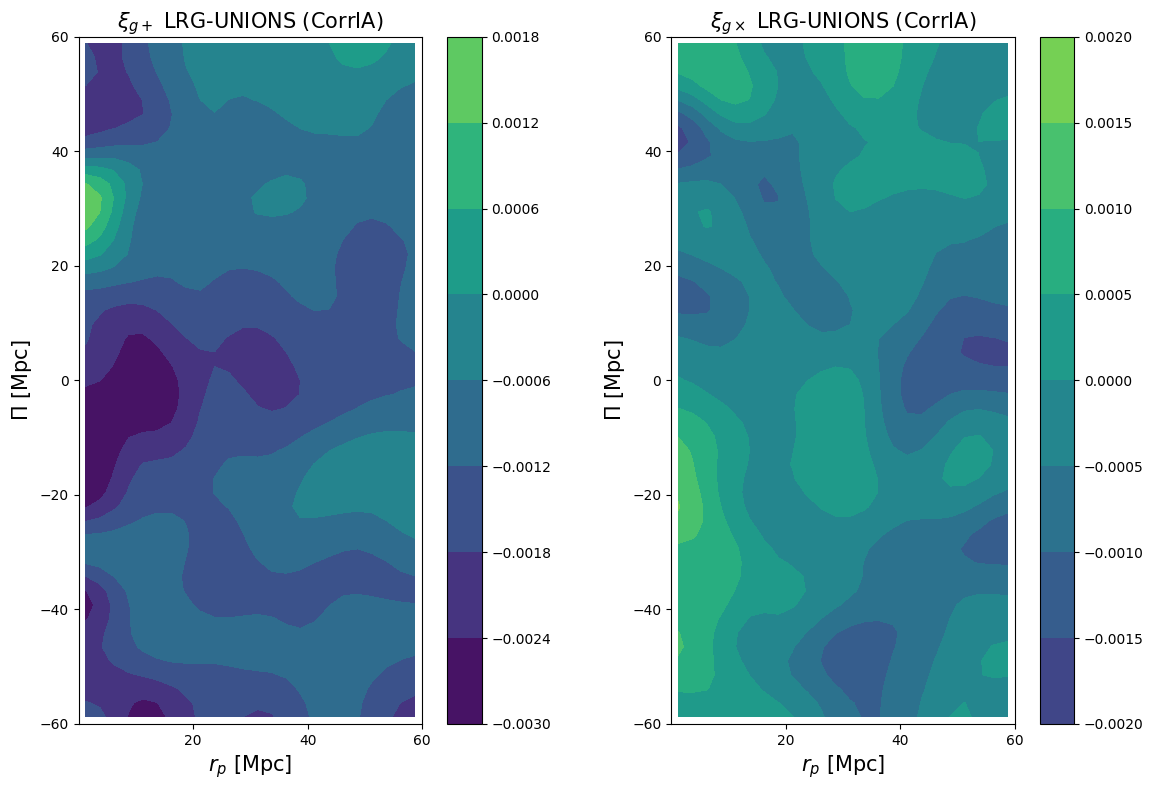

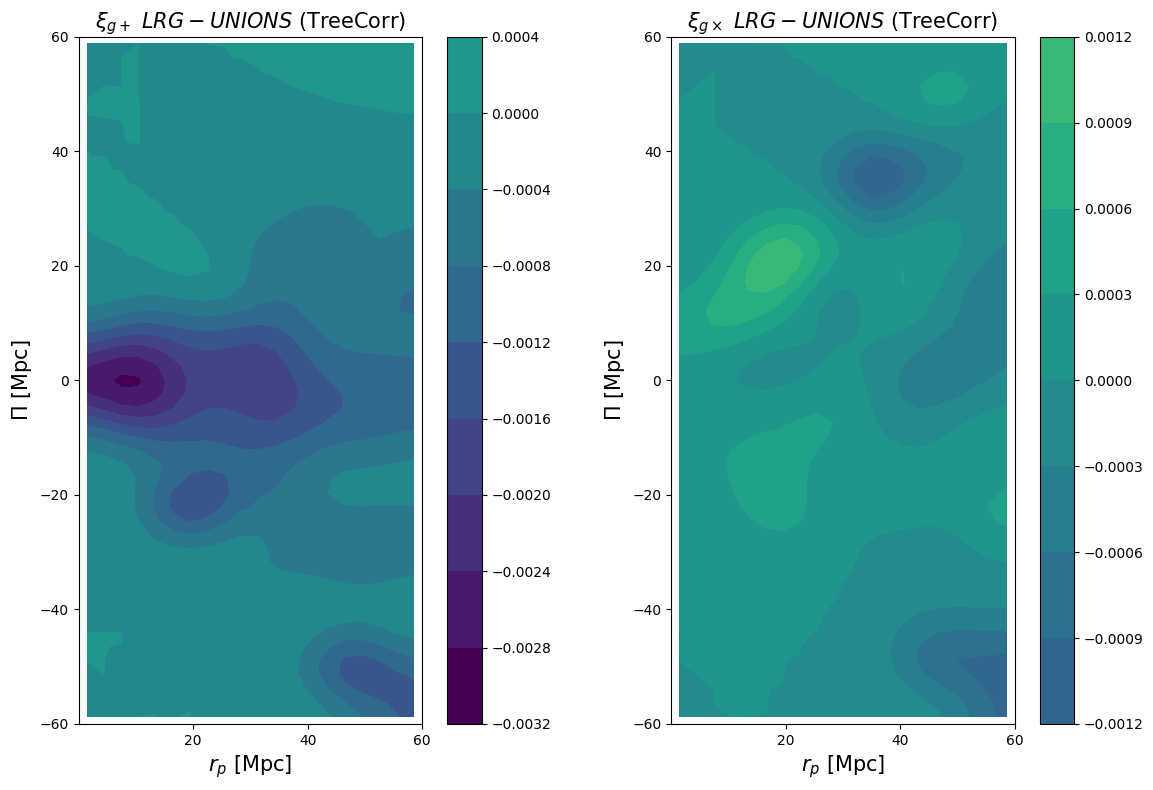

In [40]:
make_rsd_diagram(stat_weighted_lrg, stat2_weighted_lrg, rmin=60, sigma=2, contourf=True, vmin=-0.003, vmax=0.003, log=False, title_p=r'$\xi_{g+}$ LRG-UNIONS (CorrIA)', title_x=r'$\xi_{g\times}$ LRG-UNIONS (CorrIA)')

make_rsd_diagram(xi_gp_lrg.T, xi_gc_lrg.T, rmin=60, sigma=2, contourf=True, vmin=-0.003, vmax=0.003, log=False, title_p=r'$\xi_{g+}~LRG-UNIONS$ (TreeCorr)', title_x=r'$\xi_{g\times}~LRG-UNIONS$ (TreeCorr)')

### Computation of the dispersion of the ellipticities $(\sigma_{e_t},\sigma_{e_\times})$

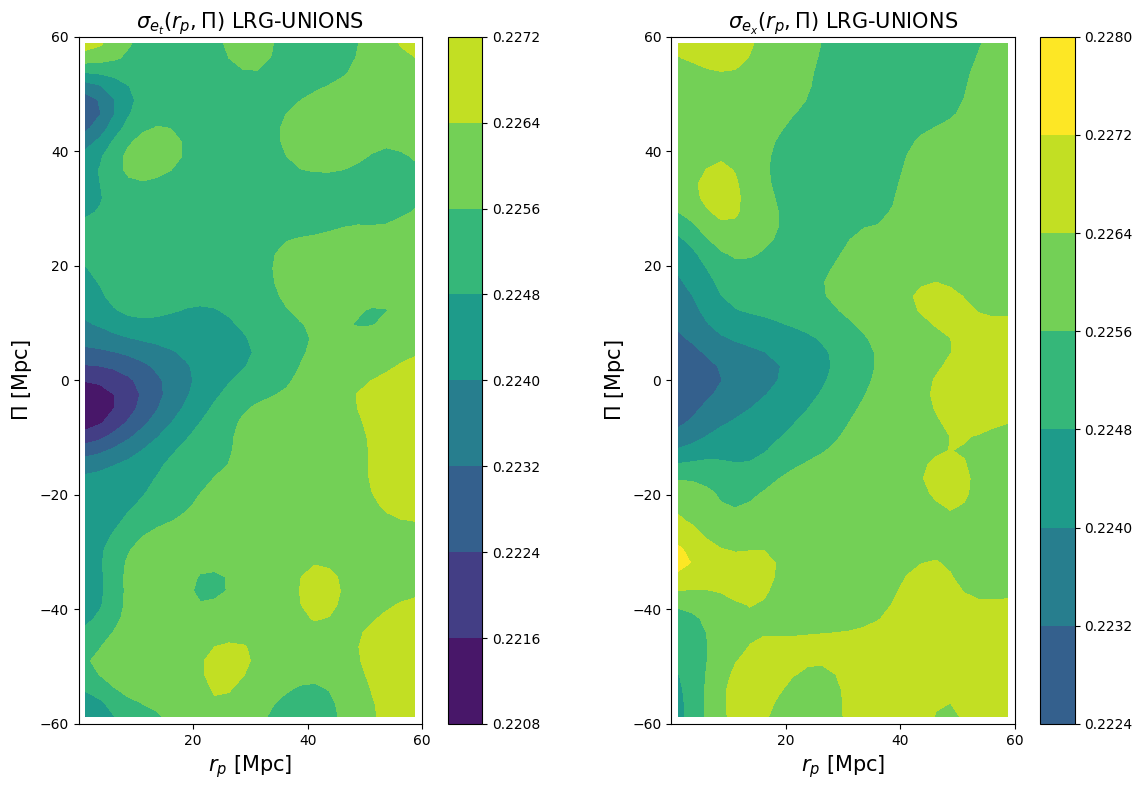

In [39]:
rp_values = pairs_lrg[:, 2] ; pi_values = pairs_lrg[:, 3] ; angle_values = pairs_lrg[:, 4] ; e1_values = e1[j_indices] ; e2_values = e2[j_indices] ; weights = w[j_indices]


e_tangential = - e1_values * np.cos(2 * angle_values) - e2_values * np.sin(2 * angle_values)
e_cross = e1_values * np.sin(2 * angle_values) - e2_values * np.cos(2 * angle_values)


valid = ~np.isnan(e_tangential) & ~np.isnan(e_cross)
rp_values = rp_values[valid]
pi_values = pi_values[valid]
e_tangential = e_tangential[valid]
e_cross = e_cross[valid]
weights = weights[valid]


std_tangential, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, e_tangential, statistic='std', bins=[rp_bins, pi_bins]
)


std_cross, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, e_cross, statistic='std', bins=[rp_bins, pi_bins]
)

make_rsd_diagram(std_tangential, std_cross, rmin=60, sigma=2, contourf=True, vmin=0.2208, vmax=0.2274, log=False,title_p=r'$\sigma_{e_t}(r_p,\Pi)$ LRG-UNIONS', title_x=r'$\sigma_{e_x}(r_p,\Pi)$ LRG-UNIONS', title_save='std_lrg.pdf')

### Same analysis for CMASS-UNIONS

In [45]:
rp_values = pairs_cmass[:, 2] ; pi_values = pairs_cmass[:, 3] ; angle_values = pairs_cmass[:, 4] ; e1_values = e1[j_indices] ; e2_values = e2[j_indices] ; weights = w[j_indices]


e_tangential = - e1_values * np.cos(2 * angle_values) - e2_values * np.sin(2 * angle_values)


valid = ~np.isnan(e_tangential)
rp_values = rp_values[valid]
pi_values = pi_values[valid]
e_tangential = e_tangential[valid]
weights = weights[valid]


weighted_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, e_tangential * weights, statistic='sum', bins=[rp_bins, pi_bins]
)

weight_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, weights, statistic='sum', bins=[rp_bins, pi_bins]
)


stat_weighted_cmass = np.divide(weighted_sum, weight_sum, out=np.zeros_like(weighted_sum), where=weight_sum != 0)










rp_values = pairs_cmass[:, 2] ; pi_values = pairs_cmass[:, 3] ; angle_values = pairs_cmass[:, 4] ; e1_values = e1[j_indices] ; e2_values = e2[j_indices] ; weights = w[j_indices]


e_cross = e1_values * np.sin(2 * angle_values) - e2_values * np.cos(2 * angle_values)


valid = ~np.isnan(e_cross)
rp_values = rp_values[valid]
pi_values = pi_values[valid]

e_cross = e_cross[valid]
weights = weights[valid]


weighted_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, e_cross * weights, statistic='sum', bins=[rp_bins, pi_bins]
)

weight_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, weights, statistic='sum', bins=[rp_bins, pi_bins]
)


stat2_weighted_cmass = np.divide(weighted_sum, weight_sum, out=np.zeros_like(weighted_sum), where=weight_sum != 0)

In [46]:
nrp = 20 ; npi = 50

shape_cat = treecorr.Catalog(x=x,y=y,z=z,g1=e1,g2=e2,w=w)

pi = np.linspace(-60,60,npi)


xi_gp = [] ; xi_gp = list(xi_gp) ; xi_gc = [] ; xi_gc = list(xi_gc)
rp = [] ; rp = list(rp) ; var = [] ; var = list(var)


for i in np.arange(0, npi-1):
    ng = treecorr.NGCorrelation(nbins=nrp, 
                                min_sep = 0,
                                max_sep = 60.,
                                min_rpar = pi[i],
                                max_rpar = pi[i+1],
                                bin_type='Linear',
                                bin_slop=0.1,
                                angle_slop=0.1)
    
    ng.process(shape_cat, shape_cat, metric ='Euclidean')

    xi_p = ng.raw_xi ; xi_c = ng.raw_xi_im ; var2 = ng.raw_varxi ; r = ng.logr
    xi_gp.append(xi_p) ; xi_gc.append(xi_c) ; var.append(var2) ; rp.append(r) 
    

xi_gp_cmass=np.array(xi_gp) ; xi_gc_cmass=np.array(xi_gc) ; var = np.array(var) ; r_cmass = np.array(rp)

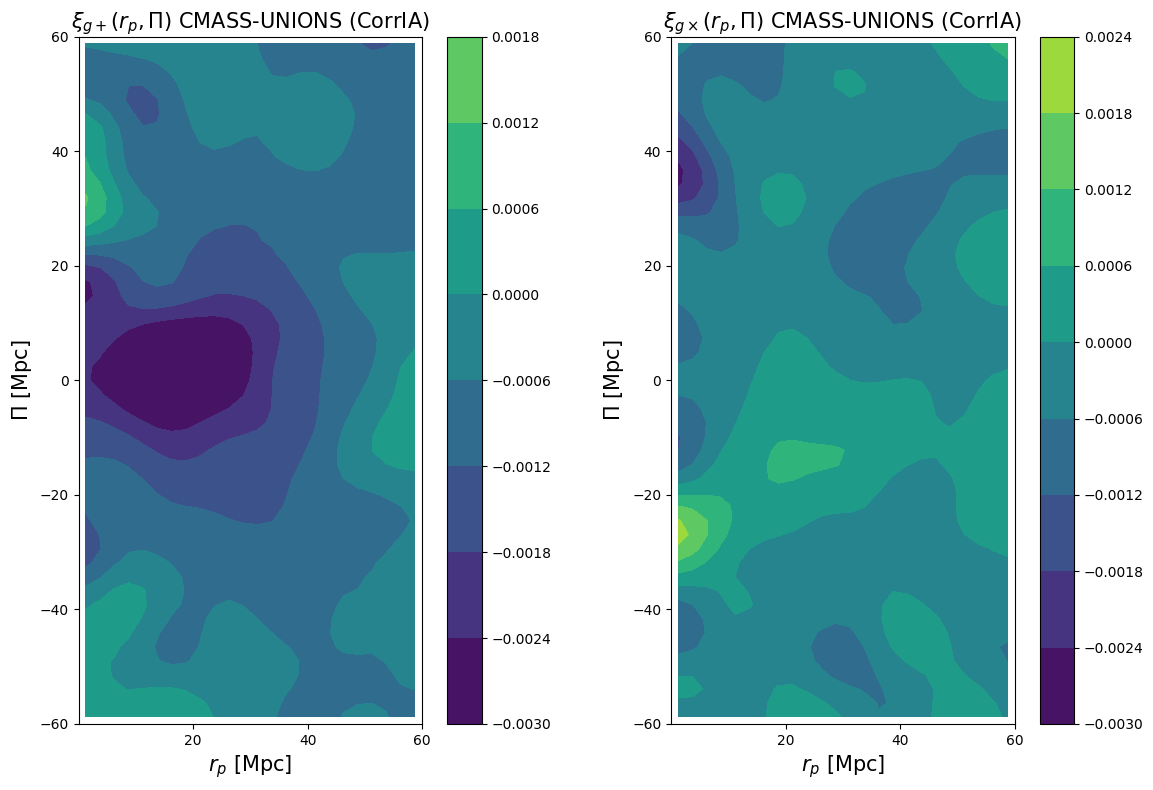

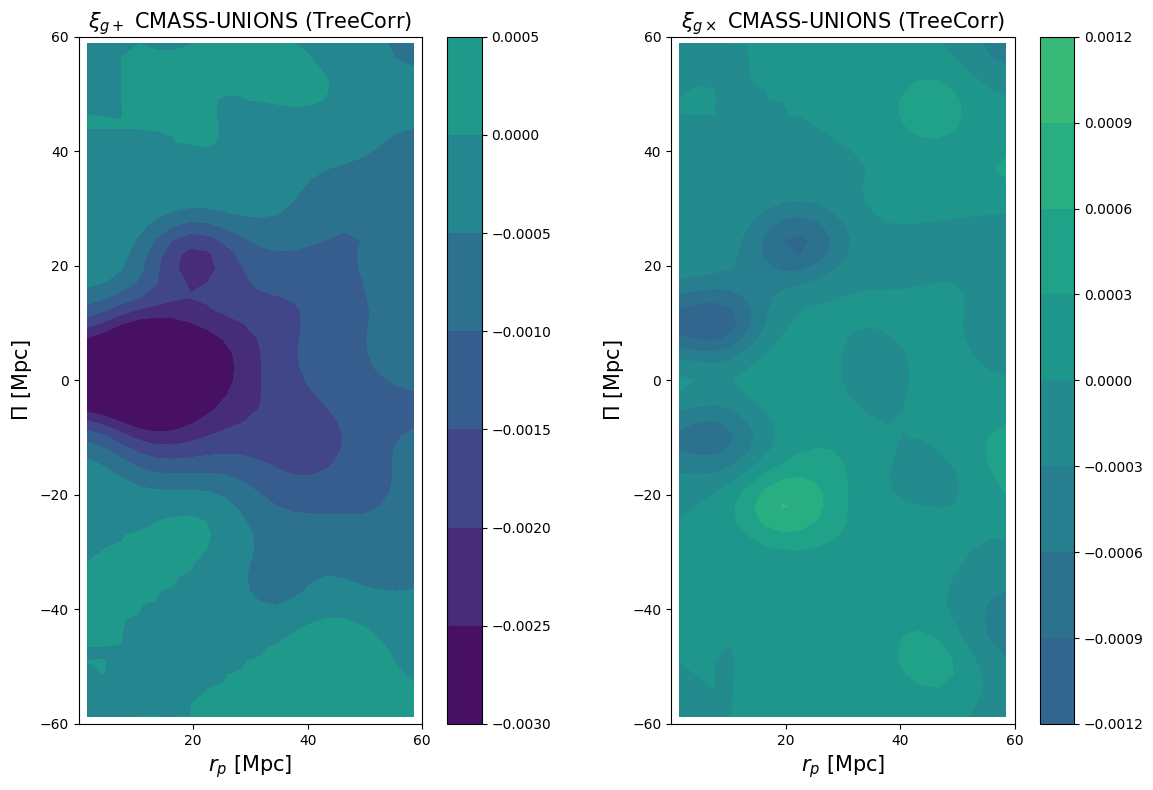

In [48]:
make_rsd_diagram(stat_weighted_cmass, stat2_weighted_cmass, rmin=60, sigma=2, contourf=True, vmin=-0.003, vmax=0.003, log=False,title_p=r'$\xi_{g+}(r_p,\Pi)$ CMASS-UNIONS (CorrIA)', title_x=r'$\xi_{g\times}(r_p,\Pi)$ CMASS-UNIONS (CorrIA)', title_save='xi_g+x_cmass.pdf')

make_rsd_diagram(xi_gp_cmass.T, xi_gc_cmass.T, rmin=60, sigma=2, contourf=True, vmin=-0.003, vmax=0.003, log=False,title_p=r'$\xi_{g+}$ CMASS-UNIONS (TreeCorr)', title_x=r'$\xi_{g\times}$ CMASS-UNIONS (TreeCorr)', title_save='xi_g+x_cmass_treecorr.pdf')

In [49]:
rp_values = pairs_cmass[:, 2] ; pi_values = pairs_cmass[:, 3] ; angle_values = pairs_cmass[:, 4] ; e1_values = e1[j_indices] ; e2_values = e2[j_indices] ; weights = w[j_indices]


e = np.sqrt(e1_values**2 + e2_values**2)


valid = ~np.isnan(e)
rp_values = rp_values[valid]
pi_values = pi_values[valid]
e = e[valid]
weights = weights[valid]


weighted_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, e * weights, statistic='sum', bins=[rp_bins, pi_bins]
)

weight_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, weights, statistic='sum', bins=[rp_bins, pi_bins]
)


stat_weighted_cmass = np.divide(weighted_sum, weight_sum, out=np.zeros_like(weighted_sum), where=weight_sum != 0)

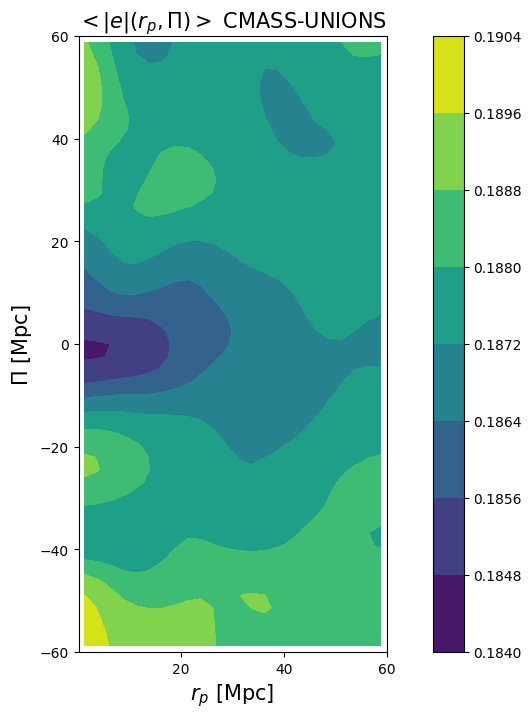

In [52]:
make_rsd_diagram2(stat_weighted_cmass, rmin=60, sigma=2, contourf=True, vmin=0.184, vmax=0.1904, log=False,title_p=r'$<\vert e \vert(r_p,\Pi)>$ CMASS-UNIONS')

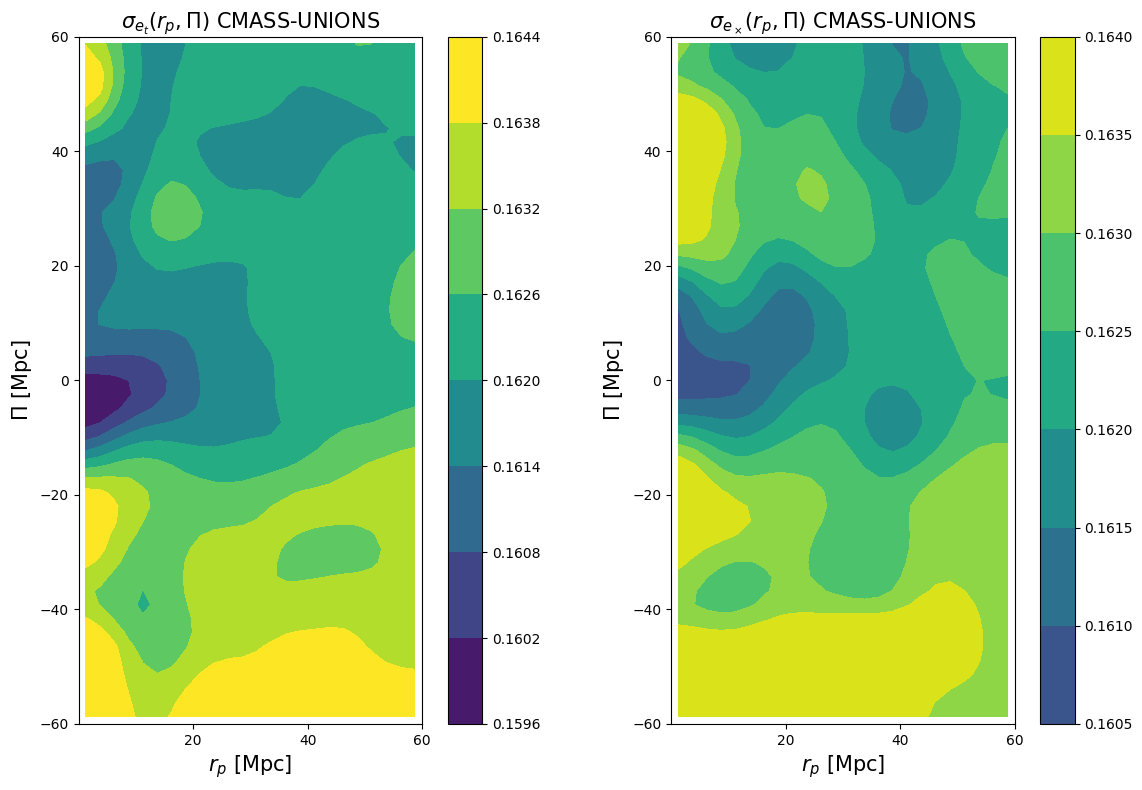

In [53]:
rp_values = pairs_cmass[:, 2] ; pi_values = pairs_cmass[:, 3] ; angle_values = pairs_cmass[:, 4] ; e1_values = e1[j_indices] ; e2_values = e2[j_indices] ; weights = w[j_indices]


e_tangential = - e1_values * np.cos(2 * angle_values) - e2_values * np.sin(2 * angle_values)
e_cross = e1_values * np.sin(2 * angle_values) - e2_values * np.cos(2 * angle_values)


valid = ~np.isnan(e_tangential) & ~np.isnan(e_cross)
rp_values = rp_values[valid]
pi_values = pi_values[valid]
e_tangential = e_tangential[valid]
e_cross = e_cross[valid]
weights = weights[valid]


std_tangential, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, e_tangential, statistic='std', bins=[rp_bins, pi_bins]
)


std_cross, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, e_cross, statistic='std', bins=[rp_bins, pi_bins]
)


make_rsd_diagram(std_tangential, std_cross, rmin=60, sigma=2, contourf=True, vmin=0.1596, vmax=0.164, log=False, title_p=r'$\sigma_{e_t}(r_p,\Pi)$ CMASS-UNIONS', title_x=r'$\sigma_{e_\times}(r_p,\Pi)$ CMASS-UNIONS')

### Same analysis for BGS-UNIONS

In [57]:
rp_values = pairs_bgs[:, 2] ; pi_values = pairs_bgs[:, 3] ; angle_values = pairs_bgs[:, 4] ; e1_values = e1[j_indices] ; e2_values = e2[j_indices]  ; weights = w[j_indices]


e_tangential = - e1_values * np.cos(2 * angle_values) - e2_values * np.sin(2 * angle_values)


valid = ~np.isnan(e_tangential)
rp_values = rp_values[valid]
pi_values = pi_values[valid]
e_tangential = e_tangential[valid]
weights = weights[valid]


weighted_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, e_tangential * weights, statistic='sum', bins=[rp_bins, pi_bins]
)

weight_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, weights, statistic='sum', bins=[rp_bins, pi_bins]
)


stat_weighted_bgs = np.divide(weighted_sum, weight_sum, out=np.zeros_like(weighted_sum), where=weight_sum != 0)











rp_values = pairs_bgs[:, 2] ; pi_values = pairs_bgs[:, 3] ; angle_values = pairs_bgs[:, 4] ; e1_values = e1[j_indices] ; e2_values = e2[j_indices]  ; weights = w[j_indices]


e_cross = e1_values * np.sin(2 * angle_values) - e2_values * np.cos(2 * angle_values)


valid = ~np.isnan(e_cross)
rp_values = rp_values[valid]
pi_values = pi_values[valid]
e_cross = e_cross[valid]
weights = weights[valid]


weighted_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, e_cross * weights, statistic='sum', bins=[rp_bins, pi_bins]
)

weight_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, weights, statistic='sum', bins=[rp_bins, pi_bins]
)


stat2_weighted_bgs = np.divide(weighted_sum, weight_sum, out=np.zeros_like(weighted_sum), where=weight_sum != 0)

In [64]:
nrp = 20 ; npi = 50

shape_cat = treecorr.Catalog(x=x,y=y,z=z,g1=e1,g2=e2,w=w)

pi = np.linspace(-60,60,npi)


xi_gp = [] ; xi_gp = list(xi_gp) ; xi_gc = [] ; xi_gc = list(xi_gc)
rp = [] ; rp = list(rp) ; var = [] ; var = list(var)


for i in np.arange(0, npi-1):
    ng = treecorr.NGCorrelation(nbins=nrp, 
                                min_sep = 0,
                                max_sep = 60.,
                                min_rpar = pi[i],
                                max_rpar = pi[i+1],
                                bin_type='Linear',
                                bin_slop=0.1,
                                angle_slop=0.1)
                                
    ng.process(shape_cat, shape_cat, metric ='Euclidean')

    xi_p = ng.raw_xi ; xi_c = ng.raw_xi_im ; var2 = ng.raw_varxi ; r = ng.logr
    xi_gp.append(xi_p) ; xi_gc.append(xi_c) ; var.append(var2) ; rp.append(r) 
    

xi_gp_bgs=np.array(xi_gp) ; xi_gc_bgs=np.array(xi_gc) ; var = np.array(var) ; r_bgs = np.array(rp)

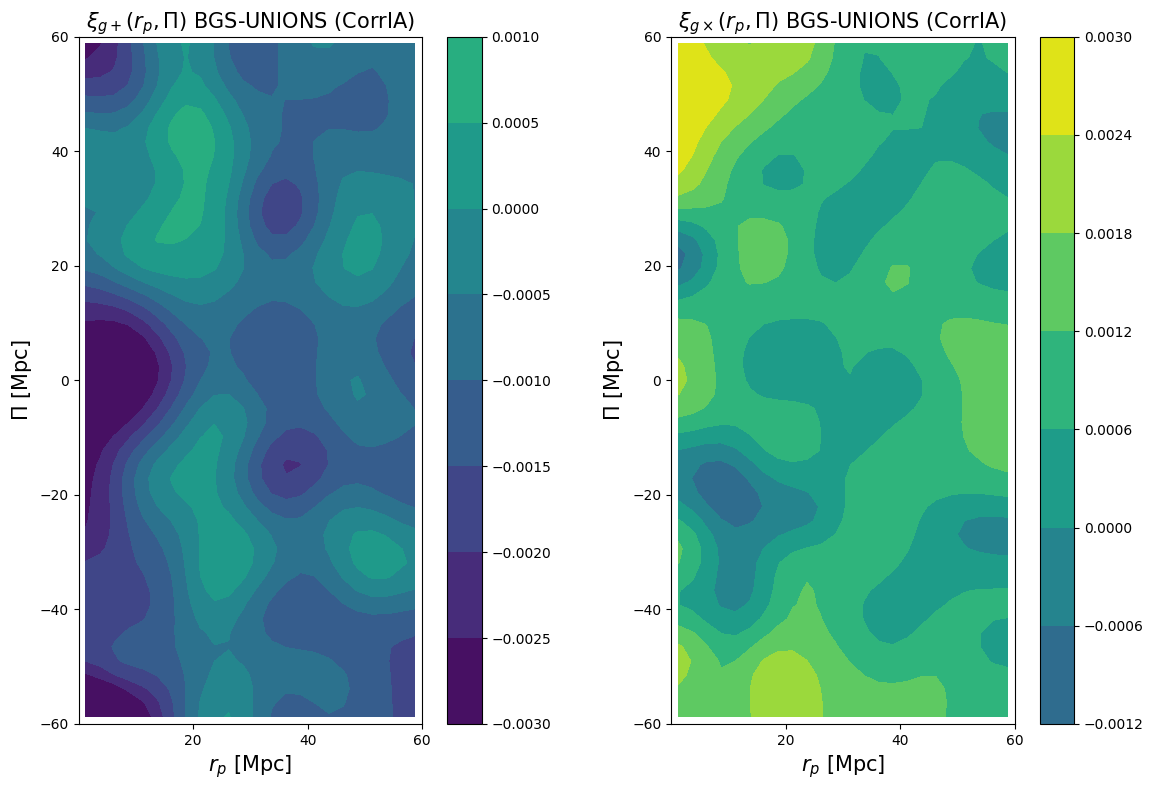

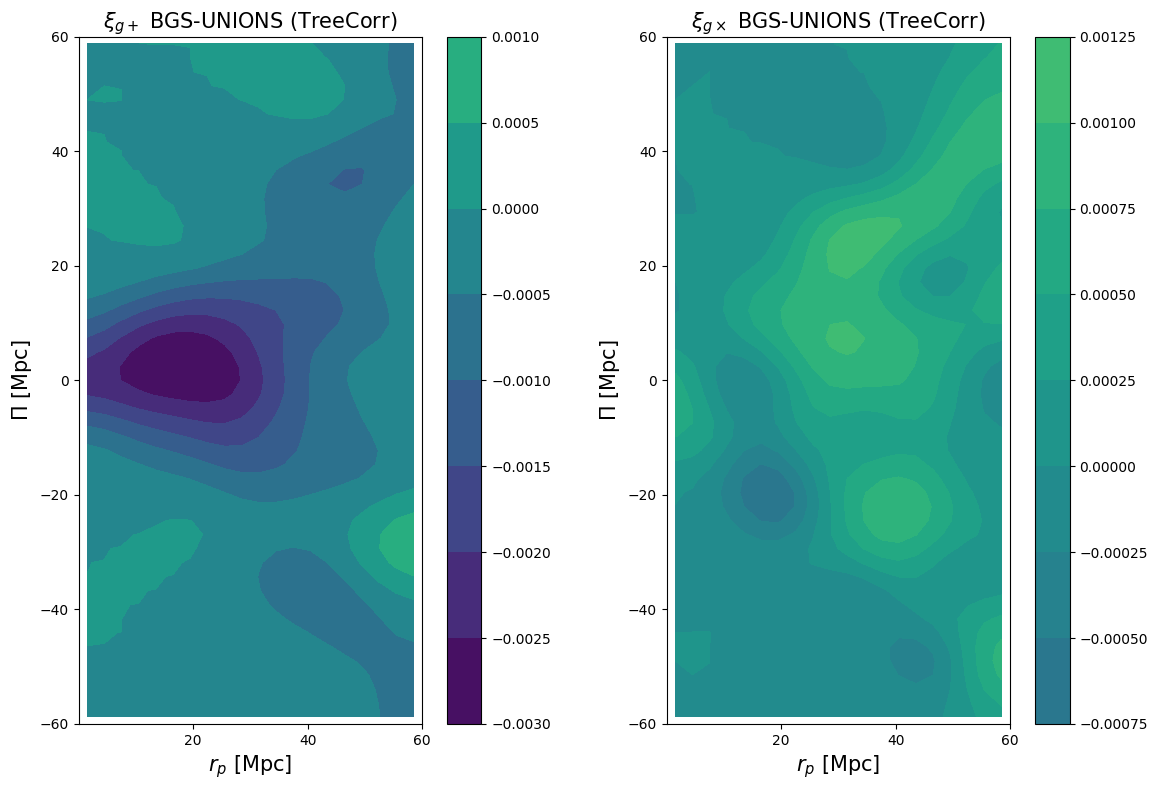

In [59]:
make_rsd_diagram(stat_weighted_bgs, stat2_weighted_bgs, rmin=60, sigma=2, contourf=True, vmin=-0.003, vmax=0.003, log=False, title_p=r'$\xi_{g+}(r_p,\Pi)$ BGS-UNIONS (CorrIA)', title_x=r'$\xi_{g\times}(r_p,\Pi)$ BGS-UNIONS (CorrIA)')

make_rsd_diagram(xi_gp_bgs.T, xi_gc_bgs.T, rmin=60, sigma=2, contourf=True, vmin=-0.003, vmax=0.003, log=False, title_p=r'$\xi_{g+}$ BGS-UNIONS (TreeCorr)', title_x=r'$\xi_{g\times}$ BGS-UNIONS (TreeCorr)')

In [60]:
rp_values = pairs_bgs[:, 2] ; pi_values = pairs_bgs[:, 3] ; angle_values = pairs_bgs[:, 4] ; e1_values = e1[j_indices] ; e2_values = e2[j_indices]  ; weights = w[j_indices]


e = np.sqrt(e1_values**2 + e2_values**2)


valid = ~np.isnan(e)
rp_values = rp_values[valid]
pi_values = pi_values[valid]
e = e[valid]
weights = weights[valid]


weighted_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, e * weights, statistic='sum', bins=[rp_bins, pi_bins]
)

weight_sum, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, weights, statistic='sum', bins=[rp_bins, pi_bins]
)


stat_weighted_bgs = np.divide(weighted_sum, weight_sum, out=np.zeros_like(weighted_sum), where=weight_sum != 0)

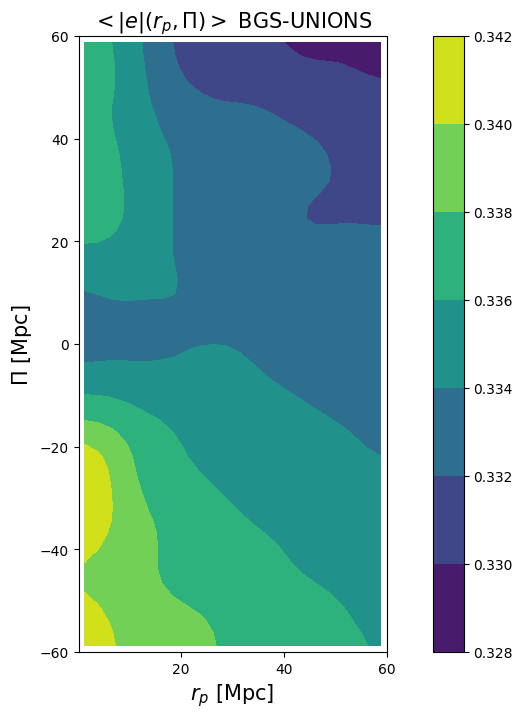

In [62]:
make_rsd_diagram2(stat_weighted_bgs, rmin=60, sigma=2, contourf=True, vmin=0.328, vmax=0.342, log=False,title_p=r'$<\vert e \vert(r_p,\Pi)>$ BGS-UNIONS')

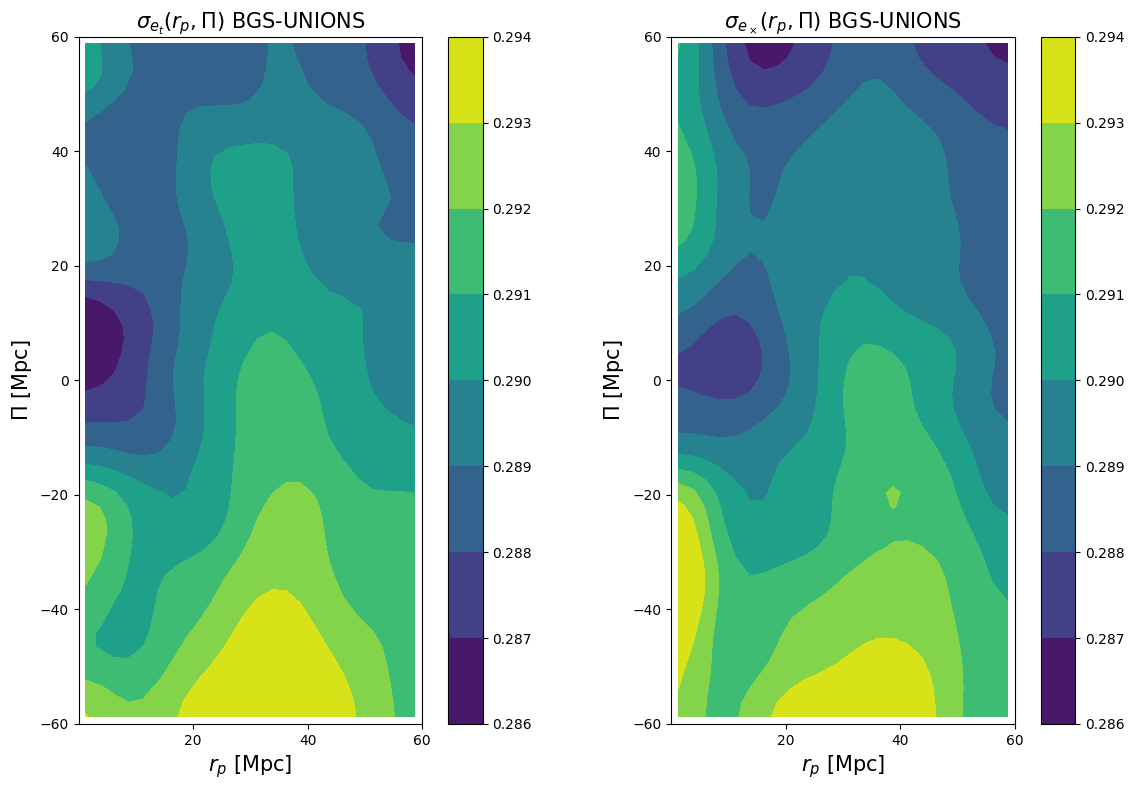

In [63]:
rp_values = pairs_bgs[:, 2] ; pi_values = pairs_bgs[:, 3] ; angle_values = pairs_bgs[:, 4] ; e1_values = e1[j_indices] ; e2_values = e2[j_indices] ; weights = w[j_indices]


e_tangential = - e1_values * np.cos(2 * angle_values) - e2_values * np.sin(2 * angle_values)
e_cross = e1_values * np.sin(2 * angle_values) - e2_values * np.cos(2 * angle_values)


valid = ~np.isnan(e_tangential) & ~np.isnan(e_cross)
rp_values = rp_values[valid]
pi_values = pi_values[valid]
e_tangential = e_tangential[valid]
e_cross = e_cross[valid]
weights = weights[valid]


std_tangential, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, e_tangential, statistic='std', bins=[rp_bins, pi_bins]
)


std_cross, _, _, _ = binned_statistic_2d(
    rp_values, pi_values, e_cross, statistic='std', bins=[rp_bins, pi_bins]
)


make_rsd_diagram(std_tangential, std_cross, rmin=60, sigma=2, contourf=True, vmin=0.286, vmax=0.294, log=False, title_p=r'$\sigma_{e_t}(r_p,\Pi)$ BGS-UNIONS', title_x=r'$\sigma_{e_\times}(r_p,\Pi)$ BGS-UNIONS')